In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [2]:
# price_data = pd.read_csv('stockPriceData-3.csv')
# # etf_indices = pd.read_csv('.csv')
# # price_data = price_data[~(price_data['Symbol'].isin(etf_indices['Symbol']))]
# price_data_500 = price_data.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
# df = price_data[price_data['Symbol'].isin(price_data_500['Symbol'])]
# df['Date'] = pd.to_datetime(df['Date'])
# master_date = df.drop_duplicates(subset='Date')[['Date']].reset_index(drop=True)
# df.set_index('Date', inplace=True)

# df = df.sort_values(by=['Date','Mcap'], ascending=[True,False])
# df = df.sort_values(['Symbol', 'Date'])
# df['PrevClose'] = df.groupby('Symbol')['Close'].shift(1)
# df['returns'] = (df['Close'] - df['PrevClose']) / df['PrevClose']

price_data = pd.read_csv('stockPriceData-3.csv')
price_data_500 = price_data.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
df = price_data_500.copy()
df['Date'] = pd.to_datetime(df['Date'])

master_date = df.drop_duplicates(subset='Date')[['Date']].reset_index(drop=True)
df.set_index('Date', inplace=True)

# Step 1: Sort by Date and descending Mcap (higher Mcap = rank 1)
df = df.sort_values(by=['Date', 'Mcap'], ascending=[True, False])

# Step 2: Create daily rank
df['Daily_Mcap_Rank'] = df.groupby('Date')['Mcap'].rank(method='first', ascending=False)

# Step 3: Define classification function
def classify_mcap(rank):
    if rank <= 100:
        return 'Large'
    elif rank <= 250:
        return 'Mid'
    else:
        return 'Small'

# Step 4: Apply classification
df['Mcap_Category'] = df['Daily_Mcap_Rank'].apply(classify_mcap)
df = df.sort_values(['Symbol', 'Date'])
df['PrevClose'] = df.groupby('Symbol')['Close'].shift(1)
df['returns'] = (df['Close'] - df['PrevClose']) / df['PrevClose']
df

Symbol      Open      High       Low      Close     Volume  \
Date                                                                        
2019-09-19     360ONE  1210.000  1270.500  1210.000  1270.5000  1777465.0   
2019-09-20     360ONE   332.250   333.500   332.250   333.5000   690162.0   
2019-09-23     360ONE   350.175   350.175   350.175   350.1750     8524.0   
2019-09-24     360ONE   367.675   367.675   367.675   367.6750   624163.0   
2019-09-25     360ONE   386.050   386.050   349.300   351.2375   132645.0   
...               ...       ...       ...       ...        ...        ...   
2025-04-29  ZYDUSWELL  1752.000  1815.100  1751.000  1802.4000    74391.0   
2025-04-30  ZYDUSWELL  1802.400  1839.000  1759.000  1765.2000    22144.0   
2025-05-02  ZYDUSWELL  1749.200  1778.500  1722.100  1733.7000    13367.0   
2025-05-05  ZYDUSWELL  1740.000  1741.100  1704.800  1723.1000    13317.0   
2025-05-06  ZYDUSWELL  1715.100  1727.900  1684.000  1694.7000    12430.0   

                     Mcap  Daily_Mcap_Rank Mcap_Category  PrevClose   returns  
Date                                                                           
2019-09-19  108152.898084            196.0           Mid        NaN       NaN  
2019-09-20  113558.414832            196.0           Mid   1270.500 -0.737505  
2019-09-23  119236.335574            190.0           Mid    333.500  0.050000  
2019-09-24  127712.100970            181.0           Mid    350.175  0.049975  
2019-09-25  122002.526864            186.0           Mid    367.675 -0.044707  
...                   ...              ...           ...        ...       ...  
2025-04-29  114690.576346            456.0         Small   1761.600  0.023161  
2025-04-30  112323.460589            458.0         Small   1802.400 -0.020639  
2025-05-02  110319.048053            461.0         Small   1765.200 -0.017845  
2025-05-05  109644.547326            468.0         Small   1733.700 -0.006114  
2025-05-06  107837.394437            467.0         Small   1723.100 -0.016482  

[2951964 rows x 11 columns]

In [3]:
y = pd.read_csv('1746812133_1208bc7f9d5aff82af8d.csv', index_col='Dates', parse_dates=['Dates'])
y = y/100
y

MF      SMB5       HML       RMW       CMA       WML  \
Dates                                                                    
2004-10-31  0.012168 -0.006901 -0.021386  0.022337 -0.030660  0.027204   
2004-11-30  0.094784  0.037202  0.010871  0.051777 -0.018473  0.018346   
2004-12-31  0.089490  0.043399  0.042841  0.022424  0.029216 -0.036782   
2005-01-31 -0.019222 -0.000578 -0.015688  0.015228 -0.009986  0.025692   
2005-02-28  0.032679  0.029722  0.047104 -0.015613 -0.007496  0.025614   
...              ...       ...       ...       ...       ...       ...   
2024-12-31 -0.021594  0.017047 -0.006544  0.003163 -0.012544  0.016039   
2025-01-31 -0.042245 -0.060533  0.025700  0.010120  0.004592 -0.063608   
2025-02-28 -0.098508 -0.062244  0.030154 -0.007777 -0.024603 -0.007605   
2025-03-31  0.071039 -0.016809  0.008277  0.007432 -0.002740  0.045413   
2025-04-30  0.022412 -0.012318  0.007823 -0.028611 -0.004204 -0.038911   

                  RF       MKT  
Dates                           
2004-10-31  0.003877  0.016045  
2004-11-30  0.004361  0.099145  
2004-12-31  0.004866  0.094356  
2005-01-31  0.004032 -0.015190  
2005-02-28  0.004195  0.036874  
...              ...       ...  
2024-12-31  0.005388 -0.016206  
2025-01-31  0.006013 -0.036232  
2025-02-28  0.004872 -0.093636  
2025-03-31  0.004888  0.075927  
2025-04-30  0.004602  0.027014  

[247 rows x 8 columns]

In [4]:
# Make sure index is datetime
df.index = pd.to_datetime(df.index)

# Get month-end close prices
month_end = df.groupby([pd.Grouper(freq='M'), 'Symbol'])['Close'].last().unstack()

# Calculate monthly returns
monthly_returns = month_end.pct_change().dropna(how='all')

# If you want to stack back to long format:
monthly_returns_long = monthly_returns.stack().reset_index()
monthly_returns_long.columns = ['Date', 'Symbol', 'Monthly Return']

print(monthly_returns.head())
print(monthly_returns_long.head())

Symbol      360ONE  3IINFOLTD  3MINDIA  63MOONS  A2ZINFRA  AADHARHFC  \
Date                                                                   
1995-06-30     NaN        NaN      NaN      NaN       NaN        NaN   
1995-07-31     NaN        NaN      NaN      NaN       NaN        NaN   
1995-08-31     NaN        NaN      NaN      NaN       NaN        NaN   
1995-09-30     NaN        NaN      NaN      NaN       NaN        NaN   
1995-10-31     NaN        NaN      NaN      NaN       NaN        NaN   

Symbol      AARTIDRUGS  AARTIIND  AAVAS  ABAN  ...  ZENITHEXPO  ZENITHINFO  \
Date                                           ...                           
1995-06-30         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-07-31         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-08-31         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-09-30         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-10-31         NaN     

In [5]:
import statsmodels.api as sm

# Align dates
monthly_returns.index = pd.to_datetime(monthly_returns.index)
y.index = pd.to_datetime(y.index)

# Subtract risk-free rate
excess_returns = monthly_returns.sub(y['RF'], axis=0)

# Define regression function
def rolling_regression(df, y_col, x_cols, window=36):
    results = []

    for end in range(window, len(df)):
        start = end - window
        y = df[y_col].iloc[start:end]
        X = df[x_cols].iloc[start:end]
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        coeffs = model.params
        coeffs.name = df.index[end]  # Label result with end-of-window date
        results.append(coeffs)

    return pd.DataFrame(results)

# Run for each stock
factor_results = {}
x_factors = ['MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML']
# x_factors = ['MF', 'SMB5', 'HML']

for symbol in excess_returns.columns:
    combined = pd.concat([excess_returns[symbol], y], axis=1).dropna()
    combined = combined.rename(columns={symbol: 'Y'})
    
    res = rolling_regression(combined, 'Y', x_factors, window=36)
    factor_results[symbol] = res

In [6]:
alpha_records = []

for symbol, coeffs_df in factor_results.items():
    if 'const' in coeffs_df.columns:
        for date, value in coeffs_df['const'].items():
            alpha_records.append({
                'Date': date,
                'Symbol': symbol,
                'const': value
            })
    else:
        print(f"Skipping {symbol} — no 'const' found.")

alpha_df = pd.DataFrame(alpha_records)
alpha_df = alpha_df.sort_values(['Date', 'Symbol']).reset_index(drop=True)

print(alpha_df.head())
print(f"Total rows: {len(alpha_df)}")

Skipping AADHARHFC — no 'const' found.
Skipping ABDL — no 'const' found.
Skipping ACI — no 'const' found.
Skipping ACMESOLAR — no 'const' found.
Skipping AETHER — no 'const' found.
Skipping AFCONS — no 'const' found.
Skipping AGARWALEYE — no 'const' found.
Skipping AIIL — no 'const' found.
Skipping AKUMS — no 'const' found.
Skipping ANANDRATHI — no 'const' found.
Skipping ATHERENERG — no 'const' found.
Skipping AZAD — no 'const' found.
Skipping BAJAJHFL — no 'const' found.
Skipping BHARTIHEXA — no 'const' found.
Skipping BIKAJI — no 'const' found.
Skipping BLUEJET — no 'const' found.
Skipping BSHSL — no 'const' found.
Skipping CAMPUS — no 'const' found.
Skipping CELLO — no 'const' found.
Skipping CHOICEIN — no 'const' found.
Skipping CMSINFO — no 'const' found.
Skipping CONCORDBIO — no 'const' found.
Skipping DATAPATTNS — no 'const' found.
Skipping DELHIVERY — no 'const' found.
Skipping DOMS — no 'const' found.
Skipping EMCURE — no 'const' found.
Skipping EMIL — no 'const' found.
Skipp

Date      Symbol     const
0      2007-10-31     3MINDIA  0.005996
1      2007-10-31  AARTIDRUGS  0.003818
2      2007-10-31    AARTIIND -0.006762
3      2007-10-31        ABAN  0.048490
4      2007-10-31         ABB  0.017709
...           ...         ...       ...
250595 2025-04-30  ZODIACLOTH -0.005212
250596 2025-04-30       ZUARI -0.005212
250597 2025-04-30    ZUARIIND -0.005212
250598 2025-04-30   ZYDUSLIFE  0.012399
250599 2025-04-30   ZYDUSWELL -0.004433

[250600 rows x 3 columns]

In [7]:
alpha_df['Date'] = pd.to_datetime(alpha_df['Date'])
alpha_df = pd.merge(alpha_df, df[['Symbol','Mcap','Mcap_Category']], on=['Date','Symbol'])
alpha_df = alpha_df.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
alpha_df

Date      Symbol     const          Mcap Mcap_Category
282   2007-10-31    RELIANCE  0.025899  4.046667e+06         Large
248   2007-10-31        ONGC -0.013898  2.665784e+06         Large
49    2007-10-31  BHARTIARTL  0.026529  1.910233e+06         Large
159   2007-10-31   ICICIBANK -0.001052  1.394688e+06         Large
50    2007-10-31        BHEL  0.027957  1.276448e+06         Large
...          ...         ...       ...           ...           ...
62157 2025-04-30  MAPMYINDIA -0.009594  9.767859e+04         Small
62113 2025-04-30  JMFINANCIL  0.013443  9.705631e+04         Small
62040 2025-04-30     GMDCLTD -0.012588  9.671970e+04         Small
62164 2025-04-30     MEDPLUS -0.026605  9.649118e+04         Small
61916 2025-04-30      ANURAS  0.004267  9.548086e+04         Small

[62321 rows x 5 columns]

In [9]:
def rolling_residual_vol(residuals_df, window=12):
    """
    residuals_df: DataFrame with ['Date', 'Symbol', 'const']
    """
    residuals_df = residuals_df.sort_values(['Symbol', 'Date'])
    residual_vol_records = []

    for symbol, group in residuals_df.groupby('Symbol'):
        group = group.set_index('Date').sort_index()
        group['residual_vol'] = group['const'].rolling(window=window).std()
        group = group.reset_index()

        residual_vol_records.append(group[['Date', 'Symbol', 'residual_vol', 'Mcap_Category']])

    result_df = pd.concat(residual_vol_records, ignore_index=True)
    return result_df

In [10]:
resid_vol_df = rolling_residual_vol(alpha_df)

# Merge back into your alpha_df
final_df = pd.merge(alpha_df, resid_vol_df, on=['Date', 'Symbol'], how='left')
final_df = final_df.dropna()
final_df

Date      Symbol     const          Mcap Mcap_Category_x  \
3926  2008-12-31    RELIANCE  0.011060  1.940099e+06           Large   
3928  2008-12-31        ONGC -0.002205  1.426842e+06           Large   
3929  2008-12-31  BHARTIARTL  0.021274  1.358174e+06           Large   
3930  2008-12-31        SBIN  0.012281  8.182336e+05           Large   
3931  2008-12-31        BHEL  0.010984  6.670200e+05           Large   
...          ...         ...       ...           ...             ...   
62313 2025-04-30  SAMMAANCAP -0.030791  1.002232e+05           Small   
62314 2025-04-30     JPPOWER -0.024109  9.964929e+04           Small   
62315 2025-04-30    MARKSANS  0.075275  9.941959e+04           Small   
62317 2025-04-30  JMFINANCIL  0.013443  9.705631e+04           Small   
62318 2025-04-30     GMDCLTD -0.012588  9.671970e+04           Small   

       residual_vol Mcap_Category_y  
3926       0.006673           Large  
3928       0.005105           Large  
3929       0.003605           Large  
3930       0.003634           Large  
3931       0.004516           Large  
...             ...             ...  
62313      0.004844           Small  
62314      0.016528           Small  
62315      0.044522           Small  
62317      0.019685           Small  
62318      0.033770           Small  

[53106 rows x 7 columns]

In [11]:
# sort by Date first (important!)
df_sorted = final_df.sort_values(['Date', 'residual_vol'])

# apply percentile rank within each Date group
df_sorted['Vol'] = df_sorted.groupby('Date')['residual_vol'] \
    .rank(pct=True, ascending=False) # multiply by 100 for percentile (0-100)
df_sorted

Date      Symbol     const           Mcap Mcap_Category_x  \
4043  2008-12-31        PGHH -0.001707   24965.552058             Mid   
4121  2008-12-31  SUNDARMFIN -0.003720   10113.228856           Small   
4235  2008-12-31  HEUBACHIND -0.010253    4129.749400           Small   
4036  2008-12-31  APOLLOHOSP  0.001119   27238.584444             Mid   
4054  2008-12-31     THERMAX  0.014624   21436.218370             Mid   
...          ...         ...       ...            ...             ...   
62315 2025-04-30    MARKSANS  0.075275   99419.594235           Small   
62289 2025-04-30        TTML -0.049438  111078.993448           Small   
62261 2025-04-30        NAVA  0.137696  128751.430516           Small   
62238 2025-04-30         ACE  0.437396  139148.714526           Small   
62308 2025-04-30    SAREGAMA  0.013839  101041.813235           Small   

       residual_vol Mcap_Category_y       Vol  
4043       0.001761             Mid  1.000000  
4121       0.001868           Small  0.996764  
4235       0.001888           Small  0.993528  
4036       0.002342             Mid  0.990291  
4054       0.002417             Mid  0.987055  
...             ...             ...       ...  
62315      0.044522           Small  0.012658  
62289      0.071343           Small  0.010127  
62261      0.081274           Small  0.007595  
62238      0.095553           Small  0.005063  
62308      0.243075           Small  0.002532  

[53106 rows x 8 columns]

In [12]:
# Merging Quality Ranks with price data universe
price_data['Date'] = pd.to_datetime(price_data['Date'])
df_sorted['Date'] = pd.to_datetime(df_sorted['Date'])
merged_df = pd.merge(df_sorted[['Date', 'Symbol', 'Vol']], price_data, on=['Date', 'Symbol'], how='outer')

merged_df[['Vol']] = merged_df.groupby('Symbol', group_keys=False)[['Vol']].apply(lambda x: x.fillna(method='ffill'))
resivol = merged_df[['Date','Symbol','Vol']]
resivol

Date     Symbol       Vol
0       1995-05-08  ANDHRAPAP       NaN
1       1995-05-08       BPCL       NaN
2       1995-05-08    DRREDDY       NaN
3       1995-05-08     GRASIM       NaN
4       1995-05-08        HEG       NaN
...            ...        ...       ...
7490519 2025-05-06       ZOTA       NaN
7490520 2025-05-06      ZUARI       NaN
7490521 2025-05-06   ZUARIIND  0.485861
7490522 2025-05-06  ZYDUSLIFE  0.311392
7490523 2025-05-06  ZYDUSWELL  0.972152

[7490524 rows x 3 columns]

In [8]:
# resivol = resivol.dropna()
alpha_df = alpha_df.dropna()
# resivol.to_csv('IVOL12M.csv')

In [15]:
# # Make sure 'Date' is a column, not index
# df_reset = df.reset_index()

# # Merge with returns
# merged = pd.merge(merged, df_reset[["Date", "Symbol", "returns"]], on=["Date", "Symbol"], how="left")
# merged

In [30]:
top_50a = (
    alpha_df[['Date', 'Symbol', 'const']]
      .sort_values(['Date', 'const'], ascending=[True, False])
      .groupby('Date')
      .head(50)
      .reset_index(drop=True)
)

# === Output Top 25 ===
top_50a

Date      Symbol     const
0    2007-10-31      ELECON  2.951107
1    2007-10-31  DSKULKARNI  0.480797
2    2007-10-31   JKLAKSHMI  0.453037
3    2007-10-31  JAICORPLTD  0.338785
4    2007-10-31    JSWSTEEL  0.302807
...         ...         ...       ...
7295 2025-04-30   CRAFTSMAN  0.036273
7296 2025-04-30     WELCORP  0.035812
7297 2025-04-30     TECHNOE  0.033496
7298 2025-04-30        PCBL  0.032719
7299 2025-04-30  MAHSCOOTER  0.032179

[7300 rows x 3 columns]

In [24]:
top_50a.to_csv()

',Date,Symbol,Vol\n0,2008-12-31,PGHH,1.0\n1,2008-12-31,SUNDARMFIN,0.9967637540453075\n2,2008-12-31,HEUBACHIND,0.9935275080906149\n3,2008-12-31,APOLLOHOSP,0.9902912621359223\n4,2008-12-31,THERMAX,0.9870550161812298\n5,2008-12-31,IGL,0.9838187702265372\n6,2008-12-31,LT,0.9805825242718447\n7,2008-12-31,PTC,0.9773462783171522\n8,2008-12-31,GRASIM,0.9741100323624595\n9,2008-12-31,MARICO,0.970873786407767\n10,2008-12-31,MATRIXLABS,0.9676375404530745\n11,2008-12-31,GSKCONS,0.9644012944983819\n12,2008-12-31,CUMMINSIND,0.9611650485436893\n13,2008-12-31,ASHOKLEY,0.9579288025889967\n14,2008-12-31,TRENT,0.9546925566343042\n15,2008-12-31,ABREL,0.9514563106796117\n16,2008-12-31,ICICIBANK,0.948220064724919\n17,2008-12-31,M&M,0.9449838187702265\n18,2008-12-31,PFIZER,0.941747572815534\n19,2008-12-31,HDFCBANK,0.9385113268608414\n20,2008-12-31,ALFALAVAL,0.9352750809061489\n21,2008-12-31,TATACHEM,0.9320388349514563\n22,2008-12-31,FINPIPE,0.9288025889967637\n23,2008-12-31,SAIL,0.9255663430420712\n24,2008-1

In [25]:
# # Step 1: Group by Date and Mcap_Category, count symbols
# category_counts = top_50a.groupby(['Date', 'Mcap_Category_y']).size().unstack(fill_value=0)

# # Step 2 (optional): reset index if you want a flat table
# category_counts = category_counts.reset_index()

# category_counts

In [26]:
# category_percent = category_counts.div(category_counts.sum(axis=1), axis=0)

# # Step 4: Plot stacked area chart
# plt.figure(figsize=(14, 7))
# category_percent.sort_index().plot(kind='area', stacked=True, colormap='Set2')

# plt.title('Large / Mid / Small Percentage Split Over Time', fontsize=16)
# plt.ylabel('Percentage Share', fontsize=12)
# plt.xlabel('Date', fontsize=12)
# plt.legend(title='Mcap Category', loc='upper left', fontsize=10)
# plt.ylim(0, 1)
# plt.tight_layout()
# plt.show()


<Figure size 1200x600 with 0 Axes>

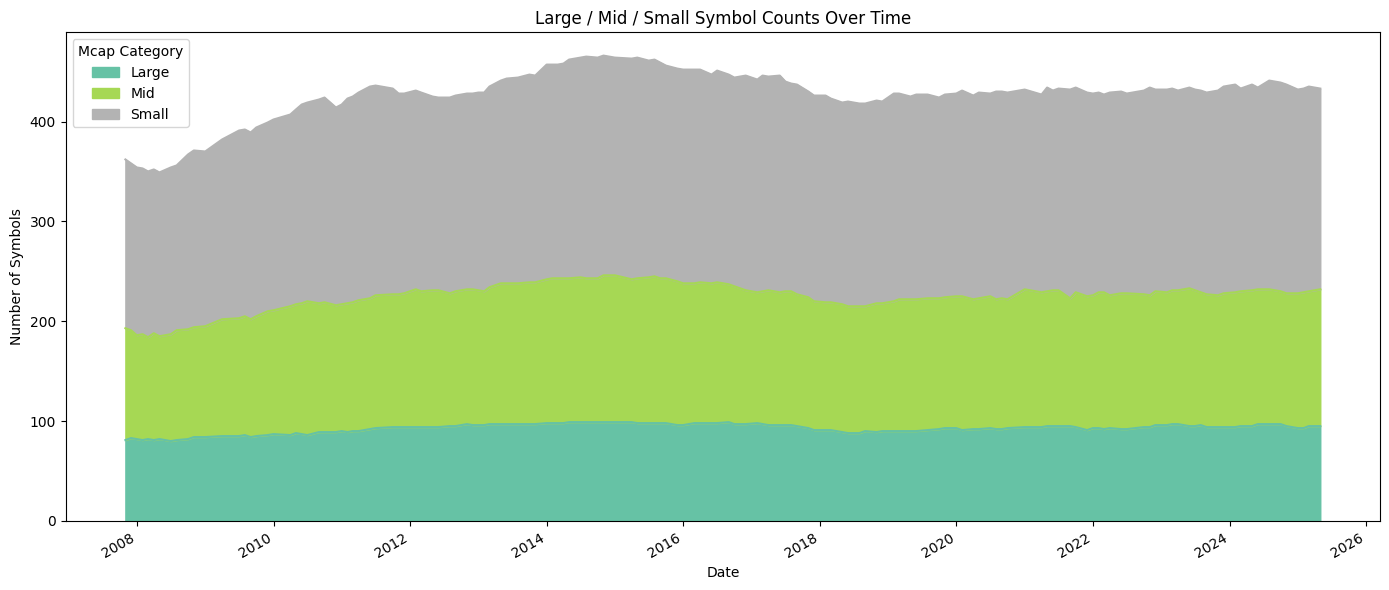

In [94]:
# Step 1: Group by Date and Mcap_Category, count symbols
category_counts = alpha_df.groupby(['Date', 'Mcap_Category']).size().unstack(fill_value=0)

# Step 2: Convert index to datetime (if not already)
category_counts.index = pd.to_datetime(category_counts.index)

# Step 3: Plot stacked area chart
plt.figure(figsize=(12, 6))
category_counts.sort_index().plot(kind='area', stacked=True, figsize=(14, 6), colormap='Set2')

plt.title('Large / Mid / Small Symbol Counts Over Time')
plt.ylabel('Number of Symbols')
plt.xlabel('Date')
plt.legend(title='Mcap Category', loc='upper left')
plt.tight_layout()
plt.show()


In [31]:
master_date = master_date.sort_values(by='Date')
portfolio = top_50a.groupby("Date")["Symbol"].apply(list).reset_index()

# Expand portfolio by date
merged = pd.merge_asof(master_date, portfolio, on="Date")

merged = merged.explode("Symbol").dropna(subset=["Symbol"])
merged = merged[merged["Date"]>= '2006-06-19'].reset_index(drop=True)
merged

Date      Symbol
0      2007-10-31      ELECON
1      2007-10-31  DSKULKARNI
2      2007-10-31   JKLAKSHMI
3      2007-10-31  JAICORPLTD
4      2007-10-31    JSWSTEEL
...           ...         ...
215795 2025-05-06   CRAFTSMAN
215796 2025-05-06     WELCORP
215797 2025-05-06     TECHNOE
215798 2025-05-06        PCBL
215799 2025-05-06  MAHSCOOTER

[215800 rows x 2 columns]

In [32]:
# Define the start date (it should start from 2006-06-19)
start_date = pd.to_datetime('2006-06-19')

# Filter the dates starting from 2006-06-19 (this ensures the start date is included)
filtered_dates = master_date[master_date['Date'] >= start_date]

# Ensure the start date is included
start_date_row = filtered_dates[filtered_dates['Date'] == start_date]

# Select every 50th date from the filtered dates (starting from the filtered list after the start date)
selected_dates = filtered_dates.iloc[::22]

# Combine the start date with the selected dates
selected_dates = pd.concat([start_date_row, selected_dates])

# Drop any NaN values and sort by date to ensure it's in the correct order
selected_dates = selected_dates.dropna().sort_values(by='Date')

combined_dates_portfolio = merged[merged['Date'].isin(selected_dates['Date'])]
combined_dates_portfolio

Date      Symbol
500    2007-11-14      ELECON
501    2007-11-14  DSKULKARNI
502    2007-11-14   JKLAKSHMI
503    2007-11-14  JAICORPLTD
504    2007-11-14    JSWSTEEL
...           ...         ...
215045 2025-04-09        GRSE
215046 2025-04-09    INDHOTEL
215047 2025-04-09     SARDAEN
215048 2025-04-09    ANANTRAJ
215049 2025-04-09  TRITURBINE

[9800 rows x 2 columns]

In [33]:
# Make sure 'Date' is a column, not index
df_reset = df.reset_index()

# Merge with returns
merged = pd.merge(merged, df_reset[["Date", "Symbol", "returns"]], on=["Date", "Symbol"], how="left")

# Compute NAV (average return across stocks each date)
nav = merged.groupby("Date")["returns"].mean()

# Apply rebalance cost on rebalance dates
rebalance_dates = pd.to_datetime(selected_dates['Date']).tolist()
nav.loc[nav.index.isin(rebalance_dates)] -= 0.0013

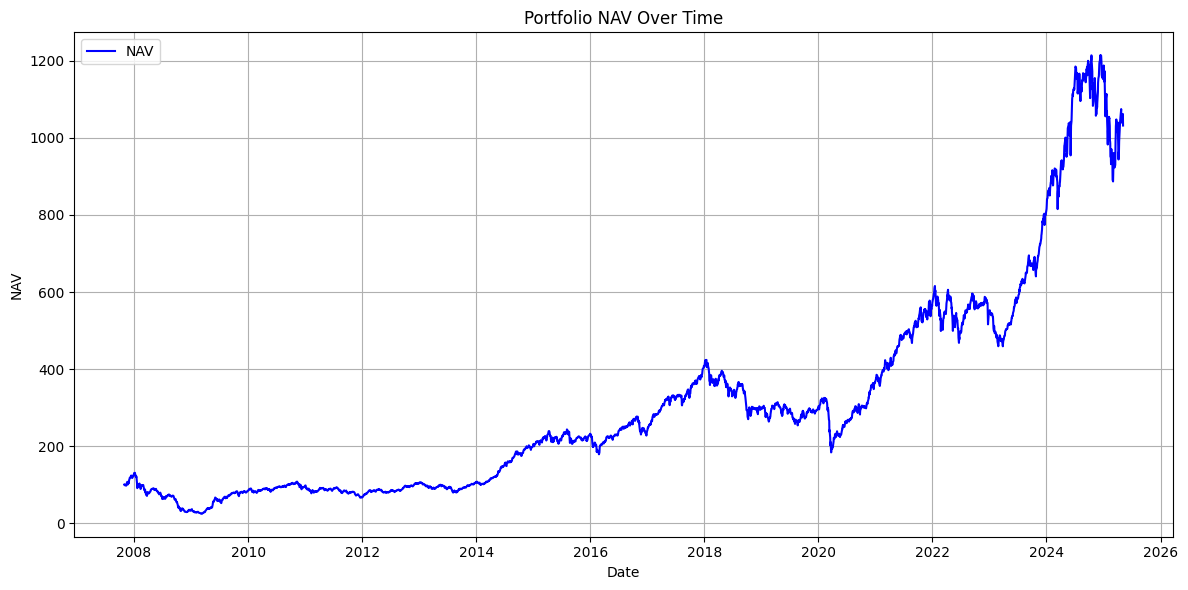

In [34]:
# Step 1: Compute NAV
nav = (1 + nav).cumprod() * 100

# Step 2: Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(nav.index, nav.values, label='NAV', color='blue')
plt.title('Portfolio NAV Over Time')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
rebased_series = nav['2010-04-01':]

# Get the value on 1st April 2014 as base
base_value = rebased_series.iloc[0]

# Rebase to start at 100
rebased_series = (rebased_series / base_value) * 100

print(rebased_series)

Date
2010-04-01     100.000000
2010-04-05     101.282509
2010-04-06     101.722614
2010-04-07     102.263356
2010-04-08     101.526974
                 ...     
2025-04-29    1214.059344
2025-04-30    1188.914764
2025-05-02    1192.069046
2025-05-05    1215.022159
2025-05-06    1180.833584
Name: returns, Length: 3727, dtype: float64


In [99]:
# rebased_series = nav['2014-04-01':]

# # Get the value on 1st April 2014 as base
# base_value = rebased_series.iloc[0]

# # Rebase to start at 100
# rebased_series = (rebased_series / base_value) * 100

# print(rebased_series)

In [100]:
# # Assuming nav is a pandas Series with Date as index
# shortv = nav.to_frame(name='Short_Vol')

# shortv

In [101]:
# # Combine into one DataFrame
# combined = longv.join(shortv)

# # Calculate daily percentage changes
# combined['Long_Return'] = combined['Long_Vol'].pct_change()
# combined['Short_Return'] = combined['Short_Vol'].pct_change()

# # Calculate daily long-short return
# combined['LongShort_Return'] = combined['Long_Return'] - combined['Short_Return']

# # Drop NaN from first row (because of pct_change)
# combined = combined.dropna()

# # Create long-short NAV, starting at 100
# combined['LongShort_NAV'] = (1 + combined['LongShort_Return']).cumprod() * 100

# # Final result
# long_short_nav = combined['LongShort_NAV']

In [36]:
# Ensure NAV is sorted
rebased_series = rebased_series.sort_index()
daily_returns = rebased_series.pct_change().dropna()

# Compute overall metrics
start_date = rebased_series.index[0]
end_date = rebased_series.index[-1]
days = (end_date - start_date).days
years = days / 365.25

cagr = (rebased_series.iloc[-1] / rebased_series.iloc[0])**(1 / years) - 1
rolling_max = rebased_series.cummax()
drawdown = rebased_series / rolling_max - 1
mdd = drawdown.min()
volatility = daily_returns.std() * np.sqrt(252)

# Calendar Year Returns
cy_returns = rebased_series.resample('Y').last().pct_change().dropna()
cy_returns.index = cy_returns.index.year
cy_df = pd.DataFrame({'CY Return': cy_returns})

# Financial Year Returns (Apr–Mar)
fy_nav = rebased_series.copy()
fy_nav.index = fy_nav.index.to_period('M')
fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
fy_returns = fy_ends.pct_change().dropna()
fy_returns.index = fy_returns.index.year + 1
fy_df = pd.DataFrame({'FY Return': fy_returns})

# Monthly returns
monthly_periods = {
    '1M Return': 21,
    '2M Return': 42,
    '3M Return': 63,
    '6M Return': 126,
    '12M Return': 252,
    '24M Return': 504
}

monthly_data = []
for label, days_back in monthly_periods.items():
    if len(rebased_series) > days_back:
        ret = rebased_series.iloc[-1] / rebased_series.iloc[-days_back] - 1
        monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})

# Summary Metrics
summary_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Value': [cagr, mdd, volatility],
    'Period': 'Overall'
})

# Calendar Year
cy_df_formatted = cy_df.rename_axis('Year').reset_index()
cy_df_formatted['Metric'] = 'CY Return'
cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})

# Financial Year
fy_df_formatted = fy_df.rename_axis('Year').reset_index()
fy_df_formatted['Metric'] = 'FY Return'
fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})

# Combine all
final_df = pd.concat([
    summary_df,
    pd.DataFrame(monthly_data),
    cy_df_formatted[['Metric', 'Period', 'Value']],
    fy_df_formatted[['Metric', 'Period', 'Value']]
], ignore_index=True)

# Optional: format as percentage
final_df['Value'] = final_df['Value'].apply(lambda x: f"{x:.2%}")

# Display


In [37]:
final_df

Metric    Value   Period
0                    CAGR   17.77%  Overall
1            Max Drawdown  -56.61%  Overall
2   Annualized Volatility   19.99%  Overall
3               1M Return   -0.57%   Latest
4               2M Return   15.80%   Latest
5               3M Return    1.42%   Latest
6               6M Return   -5.75%   Latest
7              12M Return    5.26%   Latest
8              24M Return  105.36%   Latest
9               CY Return  -30.82%     2011
10              CY Return   54.09%     2012
11              CY Return    2.58%     2013
12              CY Return   90.44%     2014
13              CY Return   13.47%     2015
14              CY Return    4.05%     2016
15              CY Return   70.98%     2017
16              CY Return  -26.65%     2018
17              CY Return   -0.54%     2019
18              CY Return   23.23%     2020
19              CY Return   55.52%     2021
20              CY Return   -3.82%     2022
21              CY Return   46.62%     2023
22              CY Return   44.39%     2024
23              CY Return  -11.24%     2025
24              FY Return   -3.82%     2013
25              FY Return    7.04%     2014
26              FY Return   25.99%     2015
27              FY Return   97.37%     2016
28              FY Return   -5.47%     2017
29              FY Return   41.75%     2018
30              FY Return   20.80%     2019
31              FY Return  -15.08%     2020
32              FY Return  -35.07%     2021
33              FY Return  104.04%     2022
34              FY Return   37.95%     2023
35              FY Return  -15.75%     2024
36              FY Return   86.85%     2025
37              FY Return   16.54%     2026
38              FY Return    0.02%     2027

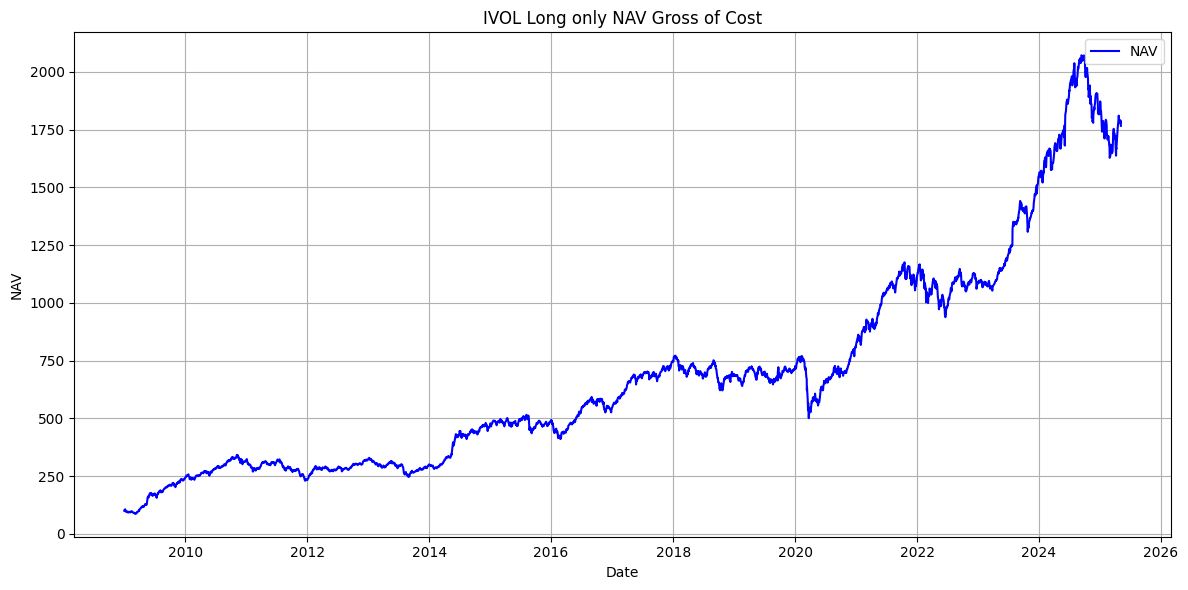

In [89]:
# Step 2: Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(rebased_series.index, rebased_series.values, label='NAV', color='blue')
plt.title('IVOL Long only NAV Gross of Cost')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Assuming nav is a pandas Series with Date as index
nav_df = nav.to_frame(name='IVOLRAJU')
nav_df

IVOLRAJU
Date                   
2008-12-31   100.114652
2009-01-01   102.602803
2009-01-02   104.300470
2009-01-05   105.920919
2009-01-06   106.626206
...                 ...
2025-04-29  2867.254832
2025-04-30  2849.134042
2025-05-02  2847.669000
2025-05-05  2869.505224
2025-05-06  2834.003290

[4029 rows x 1 columns]

In [87]:
# === DRAWNDOWN UTILITIES ===

def to_drawdown_series(nav_series):
    cum_max = nav_series.cummax()
    drawdown = (nav_series / cum_max) - 1
    return drawdown

def drawdown_details(drawdown_series):
    drawdowns = []
    peak, trough, recovery = None, None, None
    
    for i in range(1, len(drawdown_series)):
        if drawdown_series.iloc[i] == 0 and drawdown_series.iloc[i - 1] < 0:
            recovery = i
            if peak is not None and trough is not None:
                dd = {
                    'Peak': drawdown_series.index[peak],
                    'Trough': drawdown_series.index[trough],
                    'Recovery Date': drawdown_series.index[recovery],
                    'Max Drawdown': drawdown_series.iloc[trough],
                    'Peak To Trough Days': trough - peak,
                    'Recovery Days': recovery - trough
                }
                drawdowns.append(dd)
            peak, trough = None, None
        else:
            if peak is None or drawdown_series.iloc[i] == 0:
                peak = i
            if trough is None or drawdown_series.iloc[i] < drawdown_series.iloc[trough]:
                trough = i
    
    return pd.DataFrame(drawdowns)

def format_drawdown_dataframe(dd_df):
    if not dd_df.empty:
        dd_df['Max Drawdown'] = dd_df['Max Drawdown'] * 100  # convert to %
    return dd_df

def calculate_all_drawdowns(df):
    results = {}
    summary_stats = {}
    
    for column in df.columns:
        print(f"Calculating drawdowns for {column}...")
        price_series = df[column]
        dd_series = to_drawdown_series(price_series)
        dd_info = drawdown_details(dd_series)
        
        if dd_info.empty:
            summary_stats[column] = {
                'Total Drawdowns': 0,
                'Mean of Worst 5 Drawdowns': 0,
                'Mean of Worst 10 Drawdowns': 0,
                'Worst Drawdown': 0,
                'Average Recovery Days': 0,
                'Maximum Recovery Days': 0
            }
            continue
        
        dd_info = format_drawdown_dataframe(dd_info)
        dd_info['Index'] = column
        results[column] = dd_info
        
        worst_5 = dd_info.nsmallest(5, 'Max Drawdown')
        worst_10 = dd_info.nsmallest(10, 'Max Drawdown')
        
        summary_stats[column] = {
            'Total Drawdowns': len(dd_info),
            'Mean of Worst 5 Drawdowns': round(worst_5['Max Drawdown'].mean(), 4),
            'Mean of Worst 10 Drawdowns': round(worst_10['Max Drawdown'].mean(), 4),
            'Worst Drawdown': dd_info['Max Drawdown'].min(),
            'Average Recovery Days': dd_info['Recovery Days'].mean(),
            'Maximum Recovery Days': dd_info['Recovery Days'].max()
        }
    
    combined_df = pd.concat(results.values(), ignore_index=True) if results else pd.DataFrame()
    summary_df = pd.DataFrame(summary_stats).T
    summary_df.index.name = 'Index'
    summary_df.reset_index(inplace=True)
    
    return combined_df, summary_df, results

# === METRIC CALCULATION ===

def calculate_metrics(nav_series):
    nav_series = nav_series.dropna()
    daily_returns = nav_series.pct_change().dropna()
    
    start_date, end_date = nav_series.index[0], nav_series.index[-1]
    days = (end_date - start_date).days
    years = days / 365.25
    
    cagr = (nav_series.iloc[-1] / nav_series.iloc[0]) ** (1 / years) - 1
    rolling_max = nav_series.cummax()
    drawdown = nav_series / rolling_max - 1
    mdd = drawdown.min()
    volatility = daily_returns.std() * np.sqrt(252)
    
    # Calendar Year Returns
    cy_returns = nav_series.resample('Y').last().pct_change().dropna()
    cy_returns.index = cy_returns.index.year
    cy_df = pd.DataFrame({'CY Return': cy_returns})
    
    # Financial Year Returns (Apr–Mar)
    fy_nav = nav_series.copy()
    fy_nav.index = fy_nav.index.to_period('M')
    fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
    fy_returns = fy_ends.pct_change().dropna()
    fy_returns.index = fy_returns.index.year + 1
    fy_df = pd.DataFrame({'FY Return': fy_returns})
    
    # Rolling Period Returns
    monthly_periods = {
        '1M Return': 21,
        '2M Return': 42,
        '3M Return': 63,
        '6M Return': 126,
        '12M Return': 252,
        '24M Return': 504
    }
    monthly_data = []
    for label, days_back in monthly_periods.items():
        if len(nav_series) > days_back:
            ret = nav_series.iloc[-1] / nav_series.iloc[-days_back] - 1
            monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})
    
    # Summary Metrics
    summary_df = pd.DataFrame({
        'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
        'Value': [cagr, mdd, volatility],
        'Period': 'Overall'
    })
    
    # Calendar Year Formatting
    cy_df_formatted = cy_df.rename_axis('Year').reset_index()
    cy_df_formatted['Metric'] = 'CY Return'
    cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})
    
    # Financial Year Formatting
    fy_df_formatted = fy_df.rename_axis('Year').reset_index()
    fy_df_formatted['Metric'] = 'FY Return'
    fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})
    
    # Combine all
    final_df = pd.concat([
        summary_df,
        pd.DataFrame(monthly_data),
        cy_df_formatted[['Metric', 'Period', 'Value']],
        fy_df_formatted[['Metric', 'Period', 'Value']]
    ], ignore_index=True)
    
    return final_df

# === MAIN WORKFLOW ===

def full_analysis(nav_df):
    # Ensure datetime index
    if not pd.api.types.is_datetime64_any_dtype(nav_df.index):
        nav_df.index = pd.to_datetime(nav_df.index)
    
    nav_df = nav_df.sort_index()
    
    all_summaries = []
    all_drawdown_summaries = []
    
    for col in nav_df.columns:
        print(f"\n=== Processing {col} ===")
        metrics_df = calculate_metrics(nav_df[col])
        metrics_df['Index'] = col
        all_summaries.append(metrics_df)
    
    combined_metrics = pd.concat(all_summaries, ignore_index=True)
    
    # Calculate detailed drawdowns
    combined_dd, dd_summary_df, dd_results = calculate_all_drawdowns(nav_df)
    
    return combined_metrics, dd_summary_df, combined_dd

# === EXAMPLE USAGE ===

# Assuming you already have nav_df ready:
# nav_df = pd.read_csv('your_file.csv', index_col='Date', parse_dates=True)

combined_metrics, dd_summary_df, combined_dd = full_analysis(nav_df)

print("\n=== Combined Metrics ===")
print(combined_metrics)

print("\n=== Drawdown Summary ===")
print(dd_summary_df)


=== Processing NAV ===
Calculating drawdowns for NAV...

=== Combined Metrics ===
                   Metric     Value   Period Index
0                    CAGR  0.178599  Overall   NAV
1            Max Drawdown -0.370690  Overall   NAV
2   Annualized Volatility  0.166027  Overall   NAV
3               1M Return  0.025160   Latest   NAV
4               2M Return  0.074313   Latest   NAV
5               3M Return  0.004332   Latest   NAV
6               6M Return -0.071662   Latest   NAV
7              12M Return  0.023466   Latest   NAV
8              24M Return  0.578493   Latest   NAV
9               CY Return  1.395599     2009   NAV
10              CY Return  0.300459     2010   NAV
11              CY Return -0.274826     2011   NAV
12              CY Return  0.369016     2012   NAV
13              CY Return -0.091403     2013   NAV
14              CY Return  0.564115     2014   NAV
15              CY Return  0.033050     2015   NAV
16              CY Return  0.102086     2016   NAV

In [30]:
dd_summary_df

Index  Total Drawdowns  Mean of Worst 5 Drawdowns  \
0   NAV            188.0                   -25.3281   

   Mean of Worst 10 Drawdowns  Worst Drawdown  Average Recovery Days  \
0                    -18.9598       -34.91607              10.228723   

   Maximum Recovery Days  
0                  297.0

In [31]:
combined_dd.sort_values(by='Max Drawdown').tail(10)

Peak     Trough Recovery Date  Max Drawdown  Peak To Trough Days  \
165 2023-11-22 2023-11-22    2023-11-23     -0.081763                    0   
154 2023-05-31 2023-05-31    2023-06-01     -0.066158                    0   
109 2017-10-26 2017-10-27    2017-10-30     -0.044865                    1   
110 2017-10-31 2017-10-31    2017-11-01     -0.034874                    0   
80  2016-07-21 2016-07-21    2016-07-22     -0.033378                    0   
95  2017-03-17 2017-03-20    2017-03-21     -0.020918                    1   
23  2010-01-15 2010-01-15    2010-01-18     -0.019141                    0   
79  2016-07-19 2016-07-19    2016-07-20     -0.012739                    0   
173 2024-02-02 2024-02-05    2024-02-06     -0.009437                    1   
156 2023-06-16 2023-06-19    2023-06-20     -0.008841                    1   

     Recovery Days Index  
165              1   NAV  
154              1   NAV  
109              1   NAV  
110              1   NAV  
80               1   NAV  
95               1   NAV  
23               1   NAV  
79               1   NAV  
173              1   NAV  
156              1   NAV

In [75]:
combined_dd.sort_values(by='Peak').tail(10)

Peak     Trough Recovery Date  Max Drawdown  Peak To Trough Days  \
174 2024-06-18 2024-06-19    2024-06-27     -0.626699                    1   
175 2024-07-01 2024-07-02    2024-07-03     -0.214051                    1   
176 2024-07-09 2024-07-10    2024-07-11     -0.122492                    1   
177 2024-07-16 2024-07-19    2024-07-26     -1.969755                    2   
178 2024-07-31 2024-08-14    2024-08-28     -5.007707                   10   
179 2024-08-29 2024-08-29    2024-08-30     -0.065728                    0   
180 2024-09-02 2024-09-02    2024-09-05     -0.251366                    0   
181 2024-09-06 2024-09-09    2024-09-12     -1.214883                    1   
182 2024-09-13 2024-09-19    2024-09-27     -1.014818                    4   
183 2024-09-30 2024-09-30    2024-10-01     -0.075937                    0   

     Recovery Days Index  
174              6   NAV  
175              1   NAV  
176              1   NAV  
177              5   NAV  
178              9   NAV  
179              1   NAV  
180              3   NAV  
181              3   NAV  
182              6   NAV  
183              1   NAV

In [18]:
master_date = master_date.sort_values(by='Date')
portfolio = top_50a.groupby("Date")["Symbol"].apply(list).reset_index()
portfolio

Date                                             Symbol
0    2012-01-31  [MARICO, BOSCHLTD, SBIN, TATACHEM, IPCALAB, WI...
1    2012-02-01  [MARICO, BOSCHLTD, SBIN, TATACHEM, IPCALAB, WI...
2    2012-02-02  [MARICO, BOSCHLTD, SBIN, TATACHEM, IPCALAB, WI...
3    2012-02-03  [MARICO, BOSCHLTD, SBIN, TATACHEM, IPCALAB, WI...
4    2012-02-06  [MARICO, BOSCHLTD, SBIN, TATACHEM, IPCALAB, WI...
...         ...                                                ...
3263 2025-04-29  [HDFCBANK, MRF, DABUR, POWERGRID, ULTRACEMCO, ...
3264 2025-04-30  [HDFCBANK, MRF, DABUR, GAIL, ULTRACEMCO, POWER...
3265 2025-05-02  [HDFCBANK, MRF, DABUR, GAIL, ULTRACEMCO, POWER...
3266 2025-05-05  [HDFCBANK, MRF, DABUR, GAIL, ULTRACEMCO, POWER...
3267 2025-05-06  [HDFCBANK, MRF, DABUR, GAIL, ULTRACEMCO, POWER...

[3268 rows x 2 columns]

In [28]:
churnDf = combined_dates_portfolio.groupby("Date")["Symbol"].apply(set).rename("Current").reset_index()
churnDf["Previous"] = churnDf["Current"].shift()
churnDf = churnDf.dropna()
churnDf["Churn"] = churnDf.apply(lambda x : len(x["Current"] - x["Previous"])/len(x["Previous"]), axis = 1)

churnDf["Churn"].mean()

np.float64(0.7166666666666667)

In [36]:
nav_df.rename(columns={'NAV' : 'IVOL'}, inplace=True)
nav_df.to_csv('Ivol.csv')

In [31]:
nav_df.to_csv('IVOLRAJU.csv')

In [31]:
nav_df[nav_df.index == '2010-08-31']

IVOLRAJU
Date                  
2010-08-31  315.272769

In [105]:
combined_dates_portfolio.to_csv('Portdivyield.csv', index=False)

In [71]:
nav_df.to_csv('IVOL252.csv')